In [0]:

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, preprocessing, model_selection
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout

import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score,classification_report
from sklearn import metrics
import json
import ast
import time
from sklearn import linear_model


from tqdm import tqdm_notebook
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
# from catboost import CatBoostClassifier
from statistics import mean 
import gc

# import json
import altair as alt
# from  altair.vega import v3
from IPython.display import HTML

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [0]:
!ls '/content/drive/My Drive/AV_data/AmExpert_2019_MLH_28092019'

campaign_data.csv	       sample_submission_Byiv0dS.csv
coupon_item_mapping.csv        sub_R_cust_trans_coup_item_df_2.csv
customer_demographics.csv      test_QyjYwdj.csv
customer_transaction_data.csv  train.csv
item_data.csv


In [0]:
file = r'/content/drive/My Drive/AV_data/AmExpert_2019_MLH_28092019/'

train_df = pd.read_csv(file+'train.csv')
test_df = pd.read_csv(file+'test_QyjYwdj.csv')
submission_df = pd.read_csv(file+'sample_submission_Byiv0dS.csv')

coupon_item_mapping_df = pd.read_csv(file+'coupon_item_mapping.csv')
item_data_df = pd.read_csv(file+'item_data.csv')
customer_transaction_data_df = pd.read_csv(file+'customer_transaction_data.csv')
campaign_data_df = pd.read_csv(file+'campaign_data.csv')
customer_demographics_df = pd.read_csv(file+'customer_demographics.csv')


In [0]:
customer_demographics_df.isnull().sum()

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [0]:
train_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [0]:
test_df.head()

,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811


In [0]:
submission_df.head()

,id,redemption_status
0,3,0
1,4,0
2,5,0
3,8,0
4,10,0


In [0]:
print(f'Number of samples in train: {train_df.shape[0]}')
print(f'Number of columns in train: {train_df.shape[1]}')
for col in train_df.columns:
    if train_df[col].isnull().any():
        print(col, train_df[col].isnull().sum())

Number of samples in train: 78369
Number of columns in train: 5


In [0]:
print(f'Number of samples in test: {test_df.shape[0]}')
print(f'Number of columns in test: {test_df.shape[1]}')
for col in test_df.columns:
    if test_df[col].isnull().any():
        print(col, test_df[col].isnull().sum())

Number of samples in test: 50226
Number of columns in test: 4


In [0]:
train_df['redemption_status'].value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [0]:
# Normalise can be set to true to print the proportions instead of Numbers.
train_df['redemption_status'].value_counts(normalize=True)

0    0.990698
1    0.009302
Name: redemption_status, dtype: float64

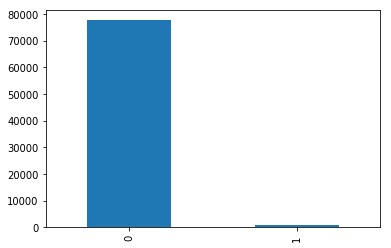

In [0]:
train_df['redemption_status'].value_counts().plot.bar()

In [0]:
train_df.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64

In [0]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [0]:
resumetable(train_df)

Dataset Shape: (78369, 5)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,78369,1,2,6,16.26
1,campaign_id,int64,0,18,13,13,9,3.00
2,coupon_id,int64,0,866,27,116,635,9.41
3,customer_id,int64,0,1428,1053,48,205,10.27
4,redemption_status,int64,0,2,0,0,0,0.08


In [0]:
# * join the datasets
train_df['is_train']  = 1
test_df['redemption_status'] = -99
test_df['is_train'] = 0

In [0]:
full_df = train_df.append(test_df)

In [0]:
full_df.shape

(128595, 6)

In [0]:
full_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,is_train
0,1,13,27,1053,0,1
1,2,13,116,48,0,1
2,6,9,635,205,0,1
3,7,13,644,1050,0,1
4,9,8,1017,1489,0,1


In [0]:
#Join the train_df and campaign_df
full_df = pd.merge(full_df, campaign_data_df, on='campaign_id', how='left')

In [0]:
full_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,is_train,campaign_type,start_date,end_date
0,1,13,27,1053,0,1,X,19/05/13,05/07/13
1,2,13,116,48,0,1,X,19/05/13,05/07/13
2,6,9,635,205,0,1,Y,11/03/13,12/04/13
3,7,13,644,1050,0,1,X,19/05/13,05/07/13
4,9,8,1017,1489,0,1,X,16/02/13,05/04/13


In [0]:
print(train_df.shape, full_df.shape, test_df.shape, campaign_data_df.shape)

(78369, 6) (128595, 9) (50226, 6) (28, 4)


In [0]:
resumetable(full_df)

Dataset Shape: (128595, 9)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,128595,1,2,6,16.97
1,campaign_id,int64,0,28,13,13,9,3.77
2,coupon_id,int64,0,1116,27,116,635,9.76
3,customer_id,int64,0,1582,1053,48,205,10.35
4,redemption_status,int64,0,3,0,0,0,1.01
5,is_train,int64,0,2,1,1,1,0.97
6,campaign_type,object,0,2,X,X,Y,0.91
7,start_date,object,0,25,19/05/13,19/05/13,11/03/13,3.69
8,end_date,object,0,26,05/07/13,05/07/13,12/04/13,3.74


## Approach & Model Building

In [0]:
coupon_item_mapping_df.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [0]:
resumetable(coupon_item_mapping_df)

Dataset Shape: (92663, 2)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,coupon_id,int64,0,1116,105,107,494,5.81
1,item_id,int64,0,36289,37,75,76,15.01


In [0]:
item_data_df.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [0]:
resumetable(item_data_df)

Dataset Shape: (74066, 4)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,item_id,int64,0,74066,1,2,3,16.18
1,brand,int64,0,5528,1,1,56,9.21
2,brand_type,object,0,2,Established,Established,Local,0.61
3,category,object,0,19,Grocery,Miscellaneous,Bakery,2.31


In [0]:
#Join the coupon item mapping and Item data
coupon_item_mapping_df_1 = pd.merge(coupon_item_mapping_df, item_data_df, on='item_id', how='left')

In [0]:
print(coupon_item_mapping_df.shape, item_data_df.shape, coupon_item_mapping_df_1.shape)

(92663, 2) (74066, 4) (92663, 5)


In [0]:
coupon_item_mapping_df_1.head()

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,Local,Grocery
1,107,75,56,Local,Grocery
2,494,76,209,Established,Grocery
3,522,77,278,Established,Grocery
4,518,77,278,Established,Grocery


In [0]:
resumetable(coupon_item_mapping_df_1)

Dataset Shape: (92663, 5)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,coupon_id,int64,0,1116,105,107,494,5.81
1,item_id,int64,0,36289,37,75,76,15.01
2,brand,int64,0,2555,56,56,209,8.20
3,brand_type,object,0,2,Local,Local,Established,0.61
4,category,object,0,17,Grocery,Grocery,Grocery,2.52


In [0]:
#Join the train , coupon_item_mapping_df_1
cust_trans_coup_item_df = pd.merge(customer_transaction_data_df, coupon_item_mapping_df_1, on='item_id', how='left')

In [0]:
cust_trans_coup_item_df.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,coupon_id,brand,brand_type,category
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,7.0,56.0,Local,Natural Products
1,2012-01-02,1501,26830,1,35.26,-10.69,0.0,20.0,56.0,Local,Natural Products
2,2012-01-02,1501,26830,1,35.26,-10.69,0.0,29.0,56.0,Local,Natural Products
3,2012-01-02,1501,54253,1,53.43,-13.89,0.0,7.0,56.0,Local,Natural Products
4,2012-01-02,1501,54253,1,53.43,-13.89,0.0,20.0,56.0,Local,Natural Products


In [0]:
resumetable(cust_trans_coup_item_df)

Dataset Shape: (2657495, 11)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,date,object,0,549,2012-01-02,2012-01-02,2012-01-02,8.99
1,customer_id,int64,0,1582,1501,1501,1501,10.31
2,item_id,int64,0,74063,26830,26830,26830,13.55
3,quantity,int64,0,9252,1,1,1,1.11
4,selling_price,float64,0,4923,35.26,35.26,35.26,7.12
5,other_discount,float64,0,1418,-10.69,-10.69,-10.69,4.83
6,coupon_discount,float64,0,232,0,0,0,0.19
7,coupon_id,float64,556134,1116,7,20,29,6.33
8,brand,float64,556134,2555,56,56,56,6.37
9,brand_type,object,556134,2,Local,Local,Local,0.85


In [0]:
print(coupon_item_mapping_df.shape, item_data_df.shape, cust_trans_coup_item_df.shape)
      

(92663, 2) (74066, 4) (2657495, 11)


In [0]:
cust_trans_coup_item_df.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,coupon_id,brand,brand_type,category
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,7.0,56.0,Local,Natural Products
1,2012-01-02,1501,26830,1,35.26,-10.69,0.0,20.0,56.0,Local,Natural Products
2,2012-01-02,1501,26830,1,35.26,-10.69,0.0,29.0,56.0,Local,Natural Products
3,2012-01-02,1501,54253,1,53.43,-13.89,0.0,7.0,56.0,Local,Natural Products
4,2012-01-02,1501,54253,1,53.43,-13.89,0.0,20.0,56.0,Local,Natural Products


In [0]:
cust_trans_coup_item_df['category'].unique()

array(['Natural Products', 'Grocery', nan, 'Meat', 'Packaged Meat',
       'Pharmaceutical', 'Seafood', 'Dairy, Juices & Snacks',
       'Prepared Food', 'Flowers & Plants', 'Skin & Hair Care',
       'Miscellaneous', 'Garden', 'Bakery', 'Vegetables (cut)', 'Salads',
       'Travel', 'Restauarant'], dtype=object)

In [0]:
cust_trans_coup_item_df['brand_type'].unique()

array(['Local', 'Established', nan], dtype=object)

In [0]:
cust_trans_coup_item_df.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,coupon_id,brand,brand_type,category
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,7.0,56.0,Local,Natural Products
1,2012-01-02,1501,26830,1,35.26,-10.69,0.0,20.0,56.0,Local,Natural Products
2,2012-01-02,1501,26830,1,35.26,-10.69,0.0,29.0,56.0,Local,Natural Products
3,2012-01-02,1501,54253,1,53.43,-13.89,0.0,7.0,56.0,Local,Natural Products
4,2012-01-02,1501,54253,1,53.43,-13.89,0.0,20.0,56.0,Local,Natural Products


In [0]:
cust_trans_coup_item_df['date'] = cust_trans_coup_item_df['date'].apply(lambda x: str(x))

def conv_dates_1(date_str):
  import datetime
  datetime_obj = datetime.datetime.strptime(str(date_str), '%Y-%m-%d')
  return datetime_obj

cust_trans_coup_item_df['date'] = cust_trans_coup_item_df['date'].apply(lambda x: conv_dates_1(x))

In [0]:
cust_trans_coup_item_df.dtypes

date               datetime64[ns]
customer_id                 int64
item_id                     int64
quantity                    int64
selling_price             float64
other_discount            float64
coupon_discount           float64
coupon_id                 float64
brand                     float64
brand_type                 object
category                   object
dtype: object

In [0]:
cust_trans_coup_item_df.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,coupon_id,brand,brand_type,category
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,7.0,56.0,Local,Natural Products
1,2012-01-02,1501,26830,1,35.26,-10.69,0.0,20.0,56.0,Local,Natural Products
2,2012-01-02,1501,26830,1,35.26,-10.69,0.0,29.0,56.0,Local,Natural Products
3,2012-01-02,1501,54253,1,53.43,-13.89,0.0,7.0,56.0,Local,Natural Products
4,2012-01-02,1501,54253,1,53.43,-13.89,0.0,20.0,56.0,Local,Natural Products


In [0]:
full_df['start_date'] = full_df['start_date'].apply(lambda x: str(x))
full_df['end_date'] = full_df['end_date'].apply(lambda x: str(x))


def conv_dates(date_str):
  import datetime
  datetime_obj = datetime.datetime.strptime(str(date_str), '%d/%m/%y')
  return datetime_obj

def conv_dates_1(date_str):
  import datetime
  datetime_obj = datetime.datetime.strptime(str(date_str), '%Y-%m-%d')
  return datetime_obj

full_df['end_date'] = full_df['end_date'].apply(lambda x: conv_dates(x))
full_df['start_date'] = full_df['start_date'].apply(lambda x: conv_dates(x))

full_df['diff_start_end_camp_dates'] = (full_df['end_date']-full_df['start_date'])
full_df['diff_start_end_camp_dates'] = full_df['diff_start_end_camp_dates'].apply(lambda x: '' if x == '' else int(str(x).split(' ')[0]))



In [0]:
full_df.dtypes

id                                    int64
campaign_id                           int64
coupon_id                             int64
customer_id                           int64
redemption_status                     int64
is_train                              int64
campaign_type                        object
start_date                   datetime64[ns]
end_date                     datetime64[ns]
diff_start_end_camp_dates             int64
dtype: object

In [0]:
full_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,is_train,campaign_type,start_date,end_date,diff_start_end_camp_dates
0,1,13,27,1053,0,1,X,2013-05-19,2013-07-05,47
1,2,13,116,48,0,1,X,2013-05-19,2013-07-05,47
2,6,9,635,205,0,1,Y,2013-03-11,2013-04-12,32
3,7,13,644,1050,0,1,X,2013-05-19,2013-07-05,47
4,9,8,1017,1489,0,1,X,2013-02-16,2013-04-05,48


In [0]:
full_df = pd.merge(full_df, customer_demographics_df, on = ['customer_id'] ,how = 'left' )
cust_detail_only = full_df[['customer_id','age_range', 'marital_status', 'rented', 
                            'family_size', 'no_of_children', 'income_bracket']].drop_duplicates()
cust_detail_only.drop(['marital_status', 'no_of_children'],axis=1,inplace=True)
cust_detail_only_mode = cust_detail_only.drop(['customer_id'],axis=1).mode(axis=0)
cust_detail_only = cust_detail_only.fillna(cust_detail_only.mode().iloc[0])
full_df.drop(['age_range', 'marital_status', 'rented', 
              'family_size', 'no_of_children', 'income_bracket'],axis=1,inplace=True)
full_df = pd.merge(full_df, cust_detail_only, on = ['customer_id'] ,how = 'left' )
full_df['income_bracket'] = full_df['income_bracket'].apply(lambda x: str(x))

cols = ['age_range', 'family_size', 'income_bracket']
for col in cols:
    if full_df[col].dtype==object:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(full_df[col].values.astype('str')))
        full_df[col] = lbl.transform(list(full_df[col].values.astype('str')))

age_range
family_size
income_bracket


In [0]:
full_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,is_train,campaign_type,start_date,end_date,diff_start_end_camp_dates,age_range,rented,family_size,income_bracket
0,1,13,27,1053,0,1,X,2013-05-19,2013-07-05,47,3,0.0,0,7
1,2,13,116,48,0,1,X,2013-05-19,2013-07-05,47,2,0.0,1,5
2,6,9,635,205,0,1,Y,2013-03-11,2013-04-12,32,3,0.0,1,9
3,7,13,644,1050,0,1,X,2013-05-19,2013-07-05,47,3,0.0,1,7
4,9,8,1017,1489,0,1,X,2013-02-16,2013-04-05,48,3,0.0,1,5


In [0]:
#check if the campaign has only one start date and end date

full_df[full_df['coupon_id']==635]['end_date'].unique()

array(['2013-04-12T00:00:00.000000000'], dtype='datetime64[ns]')

In [0]:
#checks if the customer had purcased the coupon within the campaing coipn time
sub_full_df = full_df[['start_date','end_date','coupon_id']]
sub_full_df.drop_duplicates().dropna(inplace=True)
sub_full_df.head()

,start_date,end_date,coupon_id
0,2013-05-19,2013-07-05,27
1,2013-05-19,2013-07-05,116
2,2013-03-11,2013-04-12,635
3,2013-05-19,2013-07-05,644
4,2013-02-16,2013-04-05,1017


In [0]:
sub_full_df = sub_full_df.drop_duplicates()

In [0]:
sub_full_df['coupon_id'].value_counts().head(3)

470     6
1043    6
981     5
Name: coupon_id, dtype: int64

In [0]:
sub_full_df[sub_full_df['coupon_id']==470]

,start_date,end_date,coupon_id
206,2012-08-12,2012-09-21,470
402,2013-04-22,2013-05-24,470
624,2013-05-19,2013-07-05,470
873,2013-02-16,2013-04-05,470
1945,2012-11-19,2013-01-04,470
78427,2013-08-10,2013-10-04,470


In [0]:
#Join the dataset by coupon id 
trans_tf_cust_trans_coup_item_df = pd.merge(cust_trans_coup_item_df, sub_full_df, on='coupon_id', how='left')

In [0]:
#Checks if the transaction date falls in the timeframe of the start and end date of campaign
def is_camp_tf_purchase(trans_date, start_date, end_date):
  if ((trans_date >= start_date) & (trans_date <= end_date)):
    return 1
  else: return 0
  
trans_tf_cust_trans_coup_item_df['wtf_purchased_Flag'] = trans_tf_cust_trans_coup_item_df.apply(lambda row: is_camp_tf_purchase(row['date'], row['start_date'], row['end_date']), axis=1)

In [0]:
trans_tf_cust_trans_coup_item_df.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,coupon_id,brand,brand_type,category,start_date,end_date,wtf_purchased_Flag
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,7.0,56.0,Local,Natural Products,2013-02-16,2013-04-05,0
1,2012-01-02,1501,26830,1,35.26,-10.69,0.0,20.0,56.0,Local,Natural Products,2013-05-19,2013-07-05,0
2,2012-01-02,1501,26830,1,35.26,-10.69,0.0,29.0,56.0,Local,Natural Products,2013-08-10,2013-10-04,0
3,2012-01-02,1501,54253,1,53.43,-13.89,0.0,7.0,56.0,Local,Natural Products,2013-02-16,2013-04-05,0
4,2012-01-02,1501,54253,1,53.43,-13.89,0.0,20.0,56.0,Local,Natural Products,2013-05-19,2013-07-05,0


In [0]:
trans_tf_cust_trans_coup_item_df.dtypes

date                  datetime64[ns]
customer_id                    int64
item_id                        int64
quantity                       int64
selling_price                float64
other_discount               float64
coupon_discount              float64
coupon_id                    float64
brand                        float64
brand_type                    object
category                      object
start_date            datetime64[ns]
end_date              datetime64[ns]
wtf_purchased_Flag             int64
dtype: object

In [0]:
trans_tf_cust_trans_coup_item_df[trans_tf_cust_trans_coup_item_df['wtf_purchased_Flag']==1].head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,coupon_id,brand,brand_type,category,start_date,end_date,wtf_purchased_Flag
909935,2012-08-12,994,16598,2,91.90,-17.81,0.0,369.0,56.0,Local,Grocery,2012-08-12,2012-09-21,1
909957,2012-08-12,994,59351,1,106.86,-45.95,0.0,468.0,172.0,Established,Grocery,2012-08-12,2012-09-21,1
909986,2012-08-12,553,14674,1,89.05,-28.14,0.0,564.0,360.0,Established,Grocery,2012-08-12,2012-09-21,1
909995,2012-08-12,553,23622,1,120.75,-10.69,0.0,870.0,1075.0,Established,Grocery,2012-08-12,2012-09-21,1
910031,2012-08-12,858,45158,1,355.84,0.00,0.0,694.0,686.0,Established,Pharmaceutical,2012-08-12,2012-09-21,1


In [0]:
#how many times he had purcashed before the start date of campaign
def purcahsed_before(trans_date, start_date):
  if ((trans_date <= start_date)):
    return 1
  else: return 0

trans_tf_cust_trans_coup_item_df['prior_purchased_Flag'] = trans_tf_cust_trans_coup_item_df.apply(lambda row: purcahsed_before(row['date'], row['start_date']), axis=1)

In [0]:
prior_trans_tf_cust_trans_coup_item_df = trans_tf_cust_trans_coup_item_df[trans_tf_cust_trans_coup_item_df['prior_purchased_Flag']==1]

In [0]:
cols = ['brand_type', 'category']
for col in cols:
    if trans_tf_cust_trans_coup_item_df[col].dtype==object:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(trans_tf_cust_trans_coup_item_df[col].values.astype('str')))
        trans_tf_cust_trans_coup_item_df[col] = lbl.transform(list(trans_tf_cust_trans_coup_item_df[col].values.astype('str')))

brand_type
category


### Metrics prior purchase done

In [0]:
# prior_trans_tf_cust_trans_coup_item_df

#of items purchased 
gdf = prior_trans_tf_cust_trans_coup_item_df.reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='prior_cust_coup_counts')
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")


#total discounted coupons usage whichever has < 0
gdf = prior_trans_tf_cust_trans_coup_item_df[prior_trans_tf_cust_trans_coup_item_df['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='prior_cust_disc_coup_counts')
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")

#total other discounted coupons usage whichever has < 0
gdf = prior_trans_tf_cust_trans_coup_item_df[prior_trans_tf_cust_trans_coup_item_df['other_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='prior_cust_other_disc_coup_counts')
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")

#total quantity sum
gdf = prior_trans_tf_cust_trans_coup_item_df.reset_index().groupby(["customer_id", "coupon_id"])['quantity'].agg('sum').reset_index()
gdf.columns = ["customer_id", "coupon_id", "prior_quantity_sum"]
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")




# prior_trans_tf_cust_trans_coup_item_df  -- Get the metrics for only coupon claimed

#of items purchased on coupon discount
gdf = prior_trans_tf_cust_trans_coup_item_df[prior_trans_tf_cust_trans_coup_item_df['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='item_counts_on_coup_discount')
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")


#of items purchased on coupon discount - sum of quantity
gdf = prior_trans_tf_cust_trans_coup_item_df[prior_trans_tf_cust_trans_coup_item_df['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"])['quantity'].agg('sum').reset_index()
gdf.columns = ["customer_id", "coupon_id", "item_quantity_sum_on_coup_discount"]
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")


# #total selling price sum
# gdf = prior_trans_tf_cust_trans_coup_item_df[prior_trans_tf_cust_trans_coup_item_df['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"])['selling_price'].agg(['sum']).reset_index()
# gdf.columns = ["customer_id", "coupon_id", "sellingprice_sum_on_coup_discount"]
# full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")

# #total Coupon discount price sum
# gdf = prior_trans_tf_cust_trans_coup_item_df[prior_trans_tf_cust_trans_coup_item_df['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"])['coupon_discount'].agg(['sum']).reset_index()
# gdf.columns = ["customer_id", "coupon_id", "coupondiscount_sum_on_coup_discount"]
# full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")

### Metrics inside and outside the campaign timeframe

In [0]:
#of items purchased 
gdf = cust_trans_coup_item_df.reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='cust_coup_counts')
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")


#total discounted coupons usage whichever has < 0
gdf = cust_trans_coup_item_df[cust_trans_coup_item_df['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='cust_disc_coup_counts')
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")

#total other discounted coupons usage whichever has < 0
gdf = cust_trans_coup_item_df[cust_trans_coup_item_df['other_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='cust_other_disc_coup_counts')
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")

#total quantity sum
gdf = cust_trans_coup_item_df.reset_index().groupby(["customer_id", "coupon_id"])['quantity'].agg('sum').reset_index()
gdf.columns = ["customer_id", "coupon_id", "quantity_sum"]
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")




### Get the metrics for only coupon claimed

In [0]:
#of items purchased on coupon discount
gdf = cust_trans_coup_item_df[cust_trans_coup_item_df['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='item_counts_on_coup_discount')
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")

#of items purchased on coupon discount - sum of quantity
gdf = cust_trans_coup_item_df[cust_trans_coup_item_df['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"])['quantity'].agg('sum').reset_index()
gdf.columns = ["customer_id", "coupon_id", "item_quantity_sum_on_coup_discount"]
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")

#total selling price sum
gdf = cust_trans_coup_item_df[cust_trans_coup_item_df['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"])['selling_price'].agg(['sum']).reset_index()
gdf.columns = ["customer_id", "coupon_id", "sellingprice_sum_on_coup_discount"]
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")

#total Coupon discount price sum
gdf = cust_trans_coup_item_df[cust_trans_coup_item_df['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"])['coupon_discount'].agg(['sum']).reset_index()
gdf.columns = ["customer_id", "coupon_id", "coupondiscount_sum_on_coup_discount"]
full_df = pd.merge(full_df, gdf, on=["customer_id", "coupon_id"], how="left")

### Get the counts for purchasing done between campaign start and end dates

In [0]:
tf_transaction_history = trans_tf_cust_trans_coup_item_df[trans_tf_cust_trans_coup_item_df['wtf_purchased_Flag']==1]

In [0]:
tf_transaction_history['tf_diff_purch_days'] = tf_transaction_history['date']-tf_transaction_history['start_date']
tf_transaction_history['tf_diff_purch_days'] = tf_transaction_history['tf_diff_purch_days'].apply(lambda x: '' if x == '' else int(str(x).split(' ')[0]))


In [0]:
tf_uniq_cust_coupon_id = tf_transaction_history[['customer_id', 'coupon_id']].drop_duplicates()

In [0]:
#of items purchased 
gdf = tf_transaction_history.reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='cust_wt_tf_purch_counts')
tf_uniq_cust_coupon_id = pd.merge(tf_uniq_cust_coupon_id, gdf, on=["customer_id", "coupon_id"], how="left")

In [0]:
#total quantity sum
gdf = tf_transaction_history.reset_index().groupby(["customer_id", "coupon_id"])['quantity', 'selling_price',	'other_discount',	'coupon_discount'].agg('sum').reset_index()
gdf.columns = ["customer_id", "coupon_id", "tf_quantity_sum", "tf_selling_price_sum", "tf_other_discount_sum", "tf_coupon_discount_sum"]
tf_uniq_cust_coupon_id = pd.merge(tf_uniq_cust_coupon_id, gdf, on=["customer_id", "coupon_id"], how="left")

In [0]:
#total discounted coupons usage whichever has < 0
gdf = tf_transaction_history[tf_transaction_history['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='tf_cust_disc_coup_counts')
tf_uniq_cust_coupon_id = pd.merge(tf_uniq_cust_coupon_id, gdf, on=["customer_id", "coupon_id"], how="left")

In [0]:
#total other discounted coupons usage whichever has < 0
gdf = tf_transaction_history[tf_transaction_history['other_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"]).size().reset_index(name='tf_cust_other_disc_coup_counts')
tf_uniq_cust_coupon_id = pd.merge(tf_uniq_cust_coupon_id, gdf, on=["customer_id", "coupon_id"], how="left")

In [0]:
#total quantity sum
gdf = tf_transaction_history.reset_index().groupby(["customer_id", "coupon_id"])['tf_diff_purch_days'].agg('mean').reset_index()
gdf.columns = ["customer_id", "coupon_id", "tf_diff_purch_days_mean", ]
tf_uniq_cust_coupon_id = pd.merge(tf_uniq_cust_coupon_id, gdf, on=["customer_id", "coupon_id"], how="left")

In [0]:
tf_uniq_cust_coupon_id.shape

(49328, 10)

In [0]:
dfDummies = pd.get_dummies(tf_transaction_history['category'], prefix = 'category')
tf_transaction_history_Categ = pd.concat([tf_transaction_history, dfDummies], axis=1)

#total quantity sum
cols = ['category_0', 'category_1', 'category_2', 'category_3', 'category_4',
       'category_5', 'category_6', 'category_7', 'category_8', 'category_9',
       'category_10', 'category_12', 'category_13', 'category_14',
       'category_15', 'category_16']
gdf = tf_transaction_history_Categ.reset_index().groupby(["customer_id", "coupon_id"])[cols].agg('sum').reset_index()
gdf.columns = ["customer_id", "coupon_id"] + cols

tf_uniq_cust_coupon_id = pd.merge(tf_uniq_cust_coupon_id, gdf, on=["customer_id", "coupon_id"], how="left")

In [0]:
tf_transaction_history.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,coupon_id,brand,brand_type,category,start_date,end_date,wtf_purchased_Flag,prior_purchased_Flag,tf_diff_purch_days
909935,2012-08-12,994,16598,2,91.90,-17.81,0.0,369.0,56.0,1,4,2012-08-12,2012-09-21,1,1,0
909957,2012-08-12,994,59351,1,106.86,-45.95,0.0,468.0,172.0,0,4,2012-08-12,2012-09-21,1,1,0
909986,2012-08-12,553,14674,1,89.05,-28.14,0.0,564.0,360.0,0,4,2012-08-12,2012-09-21,1,1,0
909995,2012-08-12,553,23622,1,120.75,-10.69,0.0,870.0,1075.0,0,4,2012-08-12,2012-09-21,1,1,0
910031,2012-08-12,858,45158,1,355.84,0.00,0.0,694.0,686.0,0,9,2012-08-12,2012-09-21,1,1,0


In [0]:
top_20_brands = pd.DataFrame()
top_20_brands = tf_transaction_history[tf_transaction_history['prior_purchased_Flag']==1]['brand'].value_counts().head(20).reset_index()

In [0]:
top_20_brands.columns = ['brand', 'brand_cnt']

In [0]:
#select only those records with the above brand value
tf_transaction_history_top_20_brands = tf_transaction_history.loc[tf_transaction_history['brand'].isin(top_20_brands.brand.values)]

In [0]:
tf_transaction_history_top_20_brands.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,coupon_id,brand,brand_type,category,start_date,end_date,wtf_purchased_Flag,prior_purchased_Flag,tf_diff_purch_days
909935,2012-08-12,994,16598,2,91.90,-17.81,0.0,369.0,56.0,1,4,2012-08-12,2012-09-21,1,1,0
909957,2012-08-12,994,59351,1,106.86,-45.95,0.0,468.0,172.0,0,4,2012-08-12,2012-09-21,1,1,0
909995,2012-08-12,553,23622,1,120.75,-10.69,0.0,870.0,1075.0,0,4,2012-08-12,2012-09-21,1,1,0
910051,2012-08-12,680,33038,2,178.10,-198.76,0.0,468.0,172.0,0,4,2012-08-12,2012-09-21,1,1,0
910063,2012-08-12,807,9617,1,63.76,0.00,0.0,349.0,56.0,1,4,2012-08-12,2012-09-21,1,1,0


In [0]:
dfDummies = pd.get_dummies(tf_transaction_history_top_20_brands['brand'], prefix = 'brand')
tf_transaction_history_top_20_brands_brands = pd.concat([tf_transaction_history_top_20_brands, dfDummies], axis=1)

print(tf_transaction_history_top_20_brands_brands.columns)
#total quantity sum
cols = ['brand_1.0', 'brand_56.0',
       'brand_158.0', 'brand_172.0', 'brand_209.0', 'brand_278.0',
       'brand_412.0', 'brand_487.0', 'brand_544.0', 'brand_602.0',
       'brand_676.0', 'brand_681.0', 'brand_714.0', 'brand_946.0',
       'brand_967.0', 'brand_989.0', 'brand_1075.0', 'brand_1101.0',
       'brand_1124.0', 'brand_1337.0']
gdf = tf_transaction_history_top_20_brands_brands.reset_index().groupby(["customer_id", "coupon_id"])[cols].agg('sum').reset_index()
gdf.columns = ["customer_id", "coupon_id"] + cols

tf_uniq_cust_coupon_id = pd.merge(tf_uniq_cust_coupon_id, gdf, on=["customer_id", "coupon_id"], how="left")

Index(['date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount', 'coupon_id', 'brand', 'brand_type',
       'category', 'start_date', 'end_date', 'wtf_purchased_Flag',
       'prior_purchased_Flag', 'tf_diff_purch_days', 'brand_1.0', 'brand_56.0',
       'brand_158.0', 'brand_172.0', 'brand_209.0', 'brand_278.0',
       'brand_412.0', 'brand_487.0', 'brand_544.0', 'brand_602.0',
       'brand_676.0', 'brand_681.0', 'brand_714.0', 'brand_946.0',
       'brand_967.0', 'brand_989.0', 'brand_1075.0', 'brand_1101.0',
       'brand_1124.0', 'brand_1337.0'],
      dtype='object')


In [0]:
tf_transaction_history['brand_type'].value_counts()

0    114245
1     36899
Name: brand_type, dtype: int64

In [0]:
#total brandtype summ

dfDummies = pd.get_dummies(tf_transaction_history['brand_type'], prefix = 'brand_type')
tf_transaction_history_brand_type = pd.concat([tf_transaction_history, dfDummies], axis=1)


cols = ['brand_type_0', 'brand_type_1']
gdf = tf_transaction_history_brand_type.reset_index().groupby(["customer_id", "coupon_id"])[cols].agg('sum').reset_index()
gdf.columns = ["customer_id", "coupon_id"] + cols

tf_uniq_cust_coupon_id = pd.merge(tf_uniq_cust_coupon_id, gdf, on=["customer_id", "coupon_id"], how="left")

In [0]:
tf_transaction_history.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,coupon_id,brand,brand_type,category,start_date,end_date,wtf_purchased_Flag,prior_purchased_Flag,tf_diff_purch_days
909935,2012-08-12,994,16598,2,91.90,-17.81,0.0,369.0,56.0,1,4,2012-08-12,2012-09-21,1,1,0
909957,2012-08-12,994,59351,1,106.86,-45.95,0.0,468.0,172.0,0,4,2012-08-12,2012-09-21,1,1,0
909986,2012-08-12,553,14674,1,89.05,-28.14,0.0,564.0,360.0,0,4,2012-08-12,2012-09-21,1,1,0
909995,2012-08-12,553,23622,1,120.75,-10.69,0.0,870.0,1075.0,0,4,2012-08-12,2012-09-21,1,1,0
910031,2012-08-12,858,45158,1,355.84,0.00,0.0,694.0,686.0,0,9,2012-08-12,2012-09-21,1,1,0


In [0]:
#total brandType and category unique counts & sum
tf_transaction_history['BrandType_Category'] = tf_transaction_history['brand_type'].astype(str) +"_"+ tf_transaction_history["category"].astype(str) 

dfDummies = pd.get_dummies(tf_transaction_history['BrandType_Category'], prefix = 'BrandType_Category')
tf_transaction_history_brand_type_categ = pd.concat([tf_transaction_history, dfDummies], axis=1)


cols = ['BrandType_Category_0_0', 'BrandType_Category_0_1',
       'BrandType_Category_0_10', 'BrandType_Category_0_12',
       'BrandType_Category_0_13', 'BrandType_Category_0_14',
       'BrandType_Category_0_15', 'BrandType_Category_0_16',
       'BrandType_Category_0_2', 'BrandType_Category_0_3',
       'BrandType_Category_0_4', 'BrandType_Category_0_5',
       'BrandType_Category_0_6', 'BrandType_Category_0_7',
       'BrandType_Category_0_8', 'BrandType_Category_0_9',
       'BrandType_Category_1_0', 'BrandType_Category_1_1',
       'BrandType_Category_1_10', 'BrandType_Category_1_12',
       'BrandType_Category_1_13', 'BrandType_Category_1_14',
       'BrandType_Category_1_2', 'BrandType_Category_1_4',
       'BrandType_Category_1_5', 'BrandType_Category_1_7',
       'BrandType_Category_1_8', 'BrandType_Category_1_9']
gdf = tf_transaction_history_brand_type_categ[tf_transaction_history_brand_type_categ['coupon_discount'] <0].reset_index().groupby(["customer_id", "coupon_id"])[cols].agg('sum').reset_index()
gdf.columns = ["customer_id", "coupon_id"] + cols

tf_uniq_cust_coupon_id = pd.merge(tf_uniq_cust_coupon_id, gdf, on=["customer_id", "coupon_id"], how="left")

In [0]:
full_df_1 = pd.merge(full_df, tf_uniq_cust_coupon_id, on=["customer_id", "coupon_id"], how="left")

In [0]:
full_df_1.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'is_train', 'campaign_type', 'start_date', 'end_date',
       'diff_start_end_camp_dates',
       ...
       'BrandType_Category_1_10', 'BrandType_Category_1_12',
       'BrandType_Category_1_13', 'BrandType_Category_1_14',
       'BrandType_Category_1_2', 'BrandType_Category_1_4',
       'BrandType_Category_1_5', 'BrandType_Category_1_7',
       'BrandType_Category_1_8', 'BrandType_Category_1_9'],
      dtype='object', length=102)

In [0]:
dfDummies = pd.get_dummies(full_df_1['family_size'], prefix = 'family_size')
full_df_1 = pd.concat([full_df_1, dfDummies], axis=1)

dfDummies = pd.get_dummies(full_df_1['income_bracket'], prefix = 'income_bracket')
full_df_1 = pd.concat([full_df_1, dfDummies], axis=1)

dfDummies = pd.get_dummies(full_df_1['age_range'], prefix = 'age_range')
full_df_1 = pd.concat([full_df_1, dfDummies], axis=1)

In [0]:
dfDummies = pd.get_dummies(full_df_1['campaign_type'], prefix = 'campaign_type')
full_df_1 = pd.concat([full_df_1, dfDummies], axis=1)

In [0]:
full_df_1.fillna(0, inplace= True)

In [0]:
full_df_1.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'is_train', 'campaign_type', 'start_date', 'end_date',
       'diff_start_end_camp_dates',
       ...
       'income_bracket_10', 'income_bracket_11', 'age_range_0', 'age_range_1',
       'age_range_2', 'age_range_3', 'age_range_4', 'age_range_5',
       'campaign_type_X', 'campaign_type_Y'],
      dtype='object', length=127)

In [0]:
train = full_df_1[full_df_1['is_train']==1]
test = full_df_1[full_df_1['is_train']==0]

In [0]:
print(train_df.shape, train.shape, test_df.shape, test.shape)

(78369, 6) (78369, 127) (50226, 6) (50226, 127)


In [0]:
train_df = train.copy()
test_df = test.copy()

In [0]:
full_df_1.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'is_train', 'campaign_type', 'start_date', 'end_date',
       'diff_start_end_camp_dates',
       ...
       'income_bracket_10', 'income_bracket_11', 'age_range_0', 'age_range_1',
       'age_range_2', 'age_range_3', 'age_range_4', 'age_range_5',
       'campaign_type_X', 'campaign_type_Y'],
      dtype='object', length=127)

### Target Mean encoding

In [0]:
def mean_likelihood(df, cat_var, target, alpha = 0.5):
    P_c = df.groupby(cat_var)[target].transform('mean')
    P_global = df[target].mean()
    n_c = df.groupby(cat_var)[target].transform('count')
    enc = (P_c*n_c + P_global*alpha)/(n_c + alpha)
    temp = df[[cat_var]]
    temp['enc'] = enc
    return temp.groupby(cat_var).mean()

In [0]:
cat_vars = ['campaign_id',	'coupon_id',	'customer_id'
            
           ,'age_range', 'family_size', 'income_bracket'
           ]
# getting mean encoding features
cvlist = list(KFold(n_splits = 10, random_state = 1).split(train_df))
for var in cat_vars:
    mean_enc_var = np.zeros(len(train_df))
    for tr_idx, val_idx in cvlist:
        X_tr, X_val = train_df.loc[tr_idx], train_df.loc[val_idx]
        X_tr_mean = mean_likelihood(X_tr, var, 'redemption_status')
        mean_enc_var[val_idx] = X_val[var].map(X_tr_mean['enc'])
        train_df[f'mean_enc_{var}'] = mean_enc_var
    train_df[f'mean_enc_{var}'] = train_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())
    test_df[f'mean_enc_{var}'] = test_df[var].map(mean_likelihood(train_df, 
                                                                    var, 'redemption_status')['enc'])
    test_df[f'mean_enc_{var}'] = test_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())

In [0]:
train_df.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'is_train', 'campaign_type', 'start_date', 'end_date',
       'diff_start_end_camp_dates',
       ...
       'age_range_4', 'age_range_5', 'campaign_type_X', 'campaign_type_Y',
       'mean_enc_campaign_id', 'mean_enc_coupon_id', 'mean_enc_customer_id',
       'mean_enc_age_range', 'mean_enc_family_size',
       'mean_enc_income_bracket'],
      dtype='object', length=133)

In [0]:
### Count features
for col in [
             'campaign_id', 'coupon_id', 'customer_id', 
             'campaign_type', 'age_range', 'family_size', 'income_bracket',
           
            
            ['campaign_id', 'coupon_id'], ['campaign_id', 'customer_id'],
            ['campaign_id', "campaign_type"], ["campaign_id", "age_range"],
            ["campaign_id", "family_size"], ["campaign_id", "income_bracket"],
            
            
          
            ['coupon_id', "campaign_type"], ["coupon_id", "age_range"],
            ["coupon_id", "family_size"], ["coupon_id", "income_bracket"],
    
            ['customer_id', 'coupon_id'], 
            ['customer_id', "campaign_type"], ["customer_id", "age_range"],
            ["customer_id", "family_size"], ["customer_id", "income_bracket"],
    
            ['campaign_type', 'coupon_id'], 
            ["campaign_type", "age_range"],
            ["campaign_type", "family_size"], ["campaign_type", "income_bracket"], 
    
            ['age_range', 'coupon_id'], ['age_range', 'customer_id'],
            ['age_range', "campaign_type"], 
            ["age_range", "family_size"], ["age_range", "income_bracket"],
    
            ['family_size', 'coupon_id'], ['family_size', 'customer_id'],
            ['family_size', "campaign_type"], ["family_size", "age_range"],
            ["family_size", "income_bracket"],
    
            ['income_bracket', 'coupon_id'], ['income_bracket', 'customer_id'],
            ['income_bracket', "campaign_type"], ["income_bracket", "age_range"],      
            
          

           ]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = pd.concat([train_df[["id"]+ col], test_df[["id"]+ col]])
    gdf = all_df.groupby(col)["id"].count().reset_index()
    gdf.columns = col + [col_name+"_count"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")
    

In [0]:
for col in [
      'campaign_id', 'coupon_id', 'customer_id', 
             'campaign_type', 'age_range', 'family_size', 'income_bracket'
            
           ]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = pd.concat([train_df[["sellingprice_sum_on_coup_discount"]+ col], test_df[["sellingprice_sum_on_coup_discount"]+ col]])
    gdf = all_df.groupby(col)["sellingprice_sum_on_coup_discount"].agg(["mean", "min", "max", "median"]).reset_index()
    gdf.columns = col + [col_name+"_sp_mean", col_name+"_sp_min", col_name+"_sp_max",
                         col_name+"_sp_median"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")    

## Model Building

In [0]:
train_df.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'is_train', 'campaign_type', 'start_date', 'end_date',
       'diff_start_end_camp_dates',
       ...
       'age_range_sp_max', 'age_range_sp_median', 'family_size_sp_mean',
       'family_size_sp_min', 'family_size_sp_max', 'family_size_sp_median',
       'income_bracket_sp_mean', 'income_bracket_sp_min',
       'income_bracket_sp_max', 'income_bracket_sp_median'],
      dtype='object', length=201)

In [0]:
train_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,is_train,campaign_type,start_date,end_date,diff_start_end_camp_dates,age_range,rented,family_size,income_bracket,prior_cust_coup_counts,prior_cust_disc_coup_counts,prior_cust_other_disc_coup_counts,prior_quantity_sum,item_counts_on_coup_discount_x,item_quantity_sum_on_coup_discount_x,cust_coup_counts,cust_disc_coup_counts,cust_other_disc_coup_counts,quantity_sum,item_counts_on_coup_discount_y,item_quantity_sum_on_coup_discount_y,sellingprice_sum_on_coup_discount,coupondiscount_sum_on_coup_discount,cust_wt_tf_purch_counts,tf_quantity_sum,tf_selling_price_sum,tf_other_discount_sum,tf_coupon_discount_sum,tf_cust_disc_coup_counts,tf_cust_other_disc_coup_counts,tf_diff_purch_days_mean,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_12,category_13,category_14,category_15,category_16,brand_1.0,brand_56.0,brand_158.0,brand_172.0,brand_209.0,brand_278.0,brand_412.0,brand_487.0,brand_544.0,brand_602.0,brand_676.0,brand_681.0,brand_714.0,brand_946.0,brand_967.0,brand_989.0,brand_1075.0,brand_1101.0,brand_1124.0,brand_1337.0,brand_type_0,brand_type_1,BrandType_Category_0_0,BrandType_Category_0_1,BrandType_Category_0_10,BrandType_Category_0_12,BrandType_Category_0_13,BrandType_Category_0_14,BrandType_Category_0_15,BrandType_Category_0_16,BrandType_Category_0_2,BrandType_Category_0_3,BrandType_Category_0_4,BrandType_Category_0_5,BrandType_Category_0_6,BrandType_Category_0_7,BrandType_Category_0_8,BrandType_Category_0_9,BrandType_Category_1_0,BrandType_Category_1_1,BrandType_Category_1_10,BrandType_Category_1_12,BrandType_Category_1_13,BrandType_Category_1_14,BrandType_Category_1_2,BrandType_Category_1_4,BrandType_Category_1_5,BrandType_Category_1_7,BrandType_Category_1_8,BrandType_Category_1_9,family_size_0,family_size_1,family_size_2,family_size_3,family_size_4,income_bracket_0,income_bracket_1,income_bracket_2,income_bracket_3,income_bracket_4,income_bracket_5,income_bracket_6,income_bracket_7,income_bracket_8,income_bracket_9,income_bracket_10,income_bracket_11,age_range_0,age_range_1,age_range_2,age_range_3,age_range_4,age_range_5,campaign_type_X,campaign_type_Y,mean_enc_campaign_id,mean_enc_coupon_id,mean_enc_customer_id,mean_enc_age_range,mean_enc_family_size,mean_enc_income_bracket,campaign_id_count,coupon_id_count,customer_id_count,campaign_type_count,age_range_count,family_size_count,income_bracket_count,campaign_id_coupon_id_count,campaign_id_customer_id_count,campaign_id_campaign_type_count,campaign_id_age_range_count,campaign_id_family_size_count,campaign_id_income_bracket_count,coupon_id_campaign_type_count,coupon_id_age_range_count,coupon_id_family_size_count,coupon_id_income_bracket_count,customer_id_coupon_id_count,customer_id_campaign_type_count,customer_id_age_range_count,customer_id_family_size_count,customer_id_income_bracket_count,campaign_type_coupon_id_count,campaign_type_age_range_count,campaign_type_family_size_count,campaign_type_income_bracket_count,age_range_coupon_id_count,age_range_customer_id_count,age_range_campaign_type_count,age_range_family_size_count,age_range_income_bracket_count,family_size_coupon_id_count,family_size_customer_id_count,family_size_campaign_type_count,family_size_age_range_count,family_size_income_bracket_count,income_bracket_coupon_id_count,income_bracket_customer_id_count,income_bracket_campaign_type_count,income_bracket_age_range_count,campaign_id_sp_mean,campaign_id_sp_min,campaign_id_sp_max,campaign_id_sp_median,coupon_id_sp_mean,coupon_id_sp_min,coupon_id_sp_max,coupon_id_sp_median,customer_id_sp_mean,customer_id_sp_min,customer_id_sp_max,customer_id_sp_median,campaign_type_sp_mean,campaign_type_sp_min,campaign_type_sp_max,campaign_type_sp_median,age_range_sp_mean,age_range_sp_min,age_range_sp_max,age_range_sp_median,family_size_sp_mean,family_size_sp_min,family_size_sp_max,family_size_sp_median,income_bracket_sp_mean,income_bracket_sp_min,incom

In [0]:
train_X = train_df.drop(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'is_train', 'campaign_type', 'start_date', 'end_date', 'redemption_status'

                        ],axis=1)
test_X = test_df.drop(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'is_train', 'campaign_type', 'start_date', 'end_date', 'redemption_status'

                      ],axis=1)

X = train_X

y = train_df['redemption_status']
train_y = y

In [0]:
print(train_X.shape)
print(test_X.shape)

(78369, 192)
(50226, 192)


In [0]:
train_X.columns

Index(['diff_start_end_camp_dates', 'age_range', 'rented', 'family_size',
       'income_bracket', 'prior_cust_coup_counts',
       'prior_cust_disc_coup_counts', 'prior_cust_other_disc_coup_counts',
       'prior_quantity_sum', 'item_counts_on_coup_discount_x',
       ...
       'age_range_sp_max', 'age_range_sp_median', 'family_size_sp_mean',
       'family_size_sp_min', 'family_size_sp_max', 'family_size_sp_median',
       'income_bracket_sp_mean', 'income_bracket_sp_min',
       'income_bracket_sp_max', 'income_bracket_sp_median'],
      dtype='object', length=192)

In [0]:
train_X['income_bracket'].unique()

array([ 7,  5,  9,  0,  6,  1,  8,  2,  4, 10,  3, 11])

In [0]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None): 
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = 8
    params["min_data_in_leaf"] = 1
    params["learning_rate"] = 0.05
    params["bagging_fraction"] = 0.7
    params["feature_fraction"] = 0.7
    params["bagging_freq"] = 5
    params["bagging_seed"] = 0
    params["verbosity"] = -1
    params['boosting'] = 'gbdt'
    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds,
#                           feval=lgb_f1_score, 
                          valid_sets=[lgtest], 
                          early_stopping_rounds=200, verbose_eval=500)
    else:
        lgtest = lgb.Dataset(test_X)
        model = lgb.train(params, lgtrain, num_rounds
#                           , feval=lgb_f1_score
                         )

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = roc_auc_score(test_y, pred_test_y)
#         loss = f1_score(test_y, pred_test_y.round(), average='macro')        
        print(loss)
        return pred_test_y, loss, pred_test_y2, model
    else:
        return pred_test_y, loss, pred_test_y2, model

In [0]:
cv_scores = []
f1_scores = []
pred_test_full = 0

kf = model_selection.GroupKFold(n_splits=5)
# kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=30)
# for dev_index, val_index in kf.split(X_res, y_res):
for dev_index, val_index in kf.split(X, y, train_df["id"].values):
# for dev_index, val_index in kf.split(X, y):
    print(train_df["id"].loc[val_index].unique())
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_val, loss, pred_test,model = runLGB(dev_X, dev_y, val_X, val_y, test_X)
#     f1_scores.append((f1_score(val_y, pred_val.round(), average='macro')))
    pred_test_full += pred_test
    cv_scores.append(loss)
    print(cv_scores)
    print(f1_scores)
pred_test_full /= 5.
print('Avg ROC value is',sum(cv_scores)/5)


[     2     14     21 ... 128587 128592 128595]
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.999783
Early stopping, best iteration is:
[427]	valid_0's auc: 0.999793
0.9997931266893918
[0.9997931266893918]
[]
[     6     15     22 ... 128575 128581 128589]
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	valid_0's auc: 0.999652
0.9996523301534098
[0.9997931266893918, 0.9996523301534098]
[]
[     7     17     23 ... 128576 128582 128590]
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.999612
Early stopping, best iteration is:
[324]	valid_0's auc: 0.999616
0.9996160908415205
[0.9997931266893918, 0.9996523301534098, 0.9996160908415205]
[]
[     1      9     19 ... 128568 128577 128585]
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[190]	valid_0's auc: 0.999795
0.9997953461389713
[0.9997931266893918, 0.99965

In [0]:
# [0.9982967136696943, 0.997984884620343, 0.998373132842294, 0.9983528989944566, 0.998539995311388]
# []
# Avg ROC value is 0.9983095250876352

In [0]:
pred_test_full

array([8.11409923e-06, 4.66525211e-07, 2.27167954e-07, ...,
       1.31529698e-06, 7.45990428e-05, 1.90145895e-07])

In [0]:
submission_df.head()

,id,redemption_status
0,3,0.003457
1,4,0.003318
2,5,0.003315
3,8,0.003314
4,10,0.003314


In [0]:
# # Fill the is_pass variable with the predictions
submission_df['redemption_status']= pd.DataFrame(pred_test_full)

submission_df['redemption_status'] = submission_df['redemption_status']


# # Converting the submission file to csv format
submission_df.to_csv('lgb_base.csv', index=False)

In [0]:
submission_df.head()

,id,redemption_status
0,3,8.114099e-06
1,4,4.665252e-07
2,5,2.271680e-07
3,8,1.907801e-07
4,10,1.799511e-07


In [0]:
import lightgbm as lgb

def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', 
                               n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, 
                                                                            test_size = 0.25, 
                                                                            random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, 
                  eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 
                            'importance': feature_importances}).sort_values('importance', 
                                                                            ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [0]:
identify_zero_importance_features(train_X, train_y, iterations = 2)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[28]	valid_0's auc: 0.999666	valid_0's binary_logloss: 0.0346919
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[92]	valid_0's auc: 0.999808	valid_0's binary_logloss: 0.00391105

There are 114 features with 0.0 importance


(['family_size_sp_min',
  'family_size_sp_mean',
  'campaign_type_sp_max',
  'campaign_type_sp_median',
  'age_range_sp_mean',
  'income_bracket_sp_min',
  'family_size_count',
  'age_range_count',
  'campaign_type_count',
  'family_size_sp_median',
  'age_range_sp_min',
  'age_range_sp_max',
  'campaign_id_campaign_type_count',
  'age_range_sp_median',
  'family_size_sp_max',
  'income_bracket_coupon_id_count',
  'campaign_type_sp_mean',
  'campaign_type_sp_min',
  'family_size_age_range_count',
  'family_size_campaign_type_count',
  'family_size_customer_id_count',
  'family_size_coupon_id_count',
  'income_bracket_customer_id_count',
  'income_bracket_campaign_type_count',
  'age_range_campaign_type_count',
  'income_bracket_age_range_count',
  'age_range_customer_id_count',
  'age_range_coupon_id_count',
  'campaign_type_Y',
  'campaign_type_coupon_id_count',
  'customer_id_income_bracket_count',
  'customer_id_family_size_count',
  'customer_id_age_range_count',
  'campaign_id_sp_